In [ ]:
# خلية 1: استيراد المكتبات
import numpy as np
import torch
import torch.nn as nn
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

%matplotlib inline


In [ ]:
# خلية 2: ربط Google Drive
from google.colab import drive
drive.mount('/content/storage')


Mounted at /content/storage


In [ ]:
# خلية 3: تحميل المسارات والملفات
root_dir = '/content/storage/MyDrive/Datasets/'
imgs_folder = os.path.join(root_dir, 'CameraRGB/')
labels_folder = os.path.join(root_dir, 'CameraMask/')

img_files = sorted(os.listdir(imgs_folder))
label_files = sorted(os.listdir(labels_folder))

img_files = [os.path.join(imgs_folder, f) for f in img_files]
label_files = [os.path.join(labels_folder, f) for f in label_files]


/tmp/ipython-input-4-2421077935.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  raw_img = imageio.imread(img_files[sample_idx])
/tmp/ipython-input-4-2421077935.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  raw_mask = imageio.imread(label_files[sample_idx])


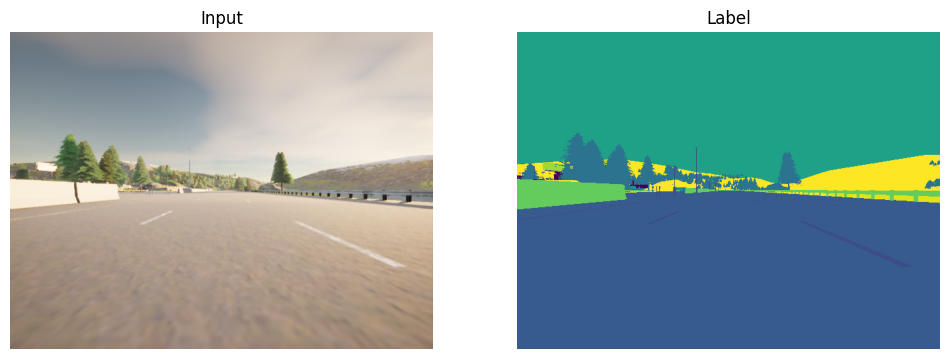

In [ ]:
# خلية 4: عرض صورة وماسك
sample_idx = 2
raw_img = imageio.imread(img_files[sample_idx])
raw_mask = imageio.imread(label_files[sample_idx])

fig, axes = plt.subplots(1, 2, figsize=(12, 10))
axes[0].imshow(raw_img)
axes[0].set_title('Input')
axes[0].axis('off')
axes[1].imshow(raw_mask[:, :, 0])
axes[1].set_title('Label')
axes[1].axis('off')
plt.show()


In [ ]:
# خلية 5: كلاس البيانات مع دعم Cross-Window Consistency
class CustomSegDataset(Dataset):
    def __init__(self, img_dir, lbl_dir):
        self.img_dir = img_dir
        self.lbl_dir = lbl_dir
        self.img_list = os.listdir(self.img_dir)
        self.lbl_list = os.listdir(self.lbl_dir)

        self.img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3])
        ])

        self.lbl_transform = transforms.Compose([
            transforms.Resize((192, 256), interpolation=transforms.InterpolationMode.NEAREST)
        ])

        self.crop = transforms.RandomCrop((160, 224))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        filename = self.img_list[idx]
        img_data = io.decode_png(io.read_file(os.path.join(self.img_dir, filename)))
        lbl_data = io.read_image(os.path.join(self.lbl_dir, filename))
        lbl_data, _ = torch.max(lbl_data[:3], dim=0, keepdim=True)

        img_tensor = self.img_transform(img_data)
        lbl_tensor = self.lbl_transform(lbl_data)

        concat = torch.cat([img_tensor, lbl_tensor], dim=0)
        crop1 = self.crop(concat)
        crop2 = self.crop(concat)

        img1, lbl1 = crop1[:3], crop1[3:]
        img2, lbl2 = crop2[:3], crop2[3:]

        return {
            'input1': img1,
            'input2': img2,
            'label1': lbl1,
            'label2': lbl2
        }


In [ ]:
# خلية 6: إعداد المتغيرات
BATCH = 32
NUM_EPOCHS = 80
LEARNING_RATE = 0.001
BETA1 = 0.9
BETA2 = 0.999


In [ ]:
# خلية 7: موديولات CNN
class ConvStage(nn.Module):
    def __init__(self, in_channels, out_channels=32, dropout=0.0, use_pool=True):
        super().__init__()
        self.convA = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.convB = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.activation = nn.ReLU()
        self.pooling = nn.MaxPool2d(2, 2) if use_pool else None
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None

    def forward(self, x):
        x = self.activation(self.convA(x))
        x = self.activation(self.convB(x))
        if self.dropout:
            x = self.dropout(x)
        skip = x.clone()
        if self.pooling:
            x = self.pooling(x)
        return x, skip


In [ ]:
# خلية 8: وحدة الرفع والتجميع
class UpSampleMerge(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch//2, 2, stride=2)
        self.conv1 = nn.Conv2d(in_ch//2 + skip_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.ReLU()

    def forward(self, up_input, skip_input):
        x = self.up(up_input)
        x = torch.cat([x, skip_input], dim=1)
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x


In [ ]:
# خلية 9: موديل UNet
class MiniUNet(nn.Module):
    def __init__(self, input_ch=3, base_ch=32, out_classes=23):
        super().__init__()

        self.enc1 = ConvStage(input_ch, base_ch)
        self.enc2 = ConvStage(base_ch, base_ch * 2)
        self.enc3 = ConvStage(base_ch * 2, base_ch * 4)
        self.enc4 = ConvStage(base_ch * 4, base_ch * 8, dropout=0.3)
        self.bridge = ConvStage(base_ch * 8, base_ch * 16, dropout=0.3, use_pool=False)

        self.dec1 = UpSampleMerge(base_ch * 16, base_ch * 8, base_ch * 8)
        self.dec2 = UpSampleMerge(base_ch * 8, base_ch * 4, base_ch * 4)
        self.dec3 = UpSampleMerge(base_ch * 4, base_ch * 2, base_ch * 2)
        self.dec4 = UpSampleMerge(base_ch * 2, base_ch, base_ch)

        self.output_layer = nn.Sequential(
            nn.Conv2d(base_ch, base_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(base_ch, out_classes, 1)
        )

    def forward(self, x):
        x1, s1 = self.enc1(x)
        x2, s2 = self.enc2(x1)
        x3, s3 = self.enc3(x2)
        x4, s4 = self.enc4(x3)
        x5, _ = self.bridge(x4)

        x = self.dec1(x5, s4)
        x = self.dec2(x, s3)
        x = self.dec3(x, s2)
        x = self.dec4(x, s1)

        return self.output_layer(x)


In [ ]:
# خلية 10: تهيئة الجهاز والموديل
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MiniUNet().to(device)


In [ ]:
# خلية 10.5: Augmentation
import albumentations as A
import cv2
from tqdm import tqdm
import shutil

aug_save_img_dir = os.path.join(root_dir, "Augmented/CameraRGB/")
aug_save_lbl_dir = os.path.join(root_dir, "Augmented/CameraMask/")
os.makedirs(aug_save_img_dir, exist_ok=True)
os.makedirs(aug_save_lbl_dir, exist_ok=True)

original_imgs = sorted(os.listdir(imgs_folder))
original_lbls = sorted(os.listdir(labels_folder))

augmentations = [
    A.Compose([A.HorizontalFlip(p=1.0), A.RandomBrightnessContrast(p=0.5)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=1.0)]),
    A.Compose([A.Blur(blur_limit=3, p=1.0)]),
    A.Compose([A.ElasticTransform(p=1.0, alpha=1, sigma=50, alpha_affine=50)])
]

# انسخ الصور الأصلية أولًا
for img_name, lbl_name in zip(original_imgs, original_lbls):
    shutil.copy(os.path.join(imgs_folder, img_name), os.path.join(aug_save_img_dir, img_name))
    shutil.copy(os.path.join(labels_folder, lbl_name), os.path.join(aug_save_lbl_dir, lbl_name))

# أضف augmentations
for i, transform in enumerate(augmentations):
    for j, (img_name, lbl_name) in enumerate(zip(original_imgs, original_lbls)):
        img_path = os.path.join(imgs_folder, img_name)
        lbl_path = os.path.join(labels_folder, lbl_name)

        image = cv2.imread(img_path)
        label = cv2.imread(lbl_path, cv2.IMREAD_GRAYSCALE)

        if label.shape != image.shape[:2]:
            label = cv2.resize(label, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

        augmented = transform(image=image, mask=label)
        aug_img = augmented['image']
        aug_lbl = augmented['mask']

        new_img_name = f"aug{i}_{j}_{img_name}"
        new_lbl_name = f"aug{i}_{j}_{lbl_name}"

        cv2.imwrite(os.path.join(aug_save_img_dir, new_img_name), aug_img)
        cv2.imwrite(os.path.join(aug_save_lbl_dir, new_lbl_name), aug_lbl)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-11-3085810207.py:19: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.Compose([A.ElasticTransform(p=1.0, alpha=1, sigma=50, alpha_affine=50)])


In [ ]:
# خلية 11: dataloader مع تقسيم train/test
full_dataset = CustomSegDataset(imgs_folder, labels_folder)

train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)


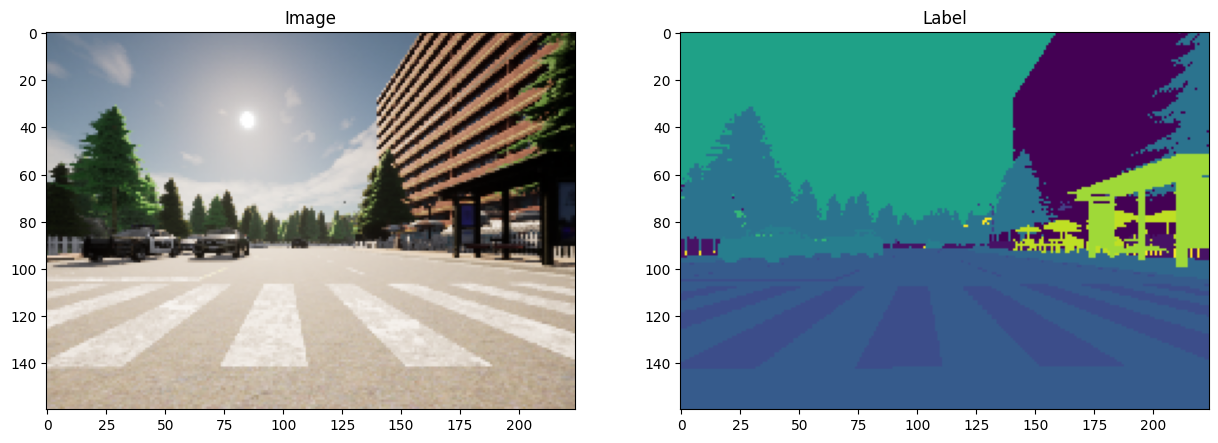

In [ ]:
# خلية 12: عرض بيانات مع crop1 من train_loader (مثال)
sample = next(iter(train_loader))
img = sample['input1'][0]
lbl = sample['label1'][0]

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(img.permute(1, 2, 0))
ax[0].set_title('Image')
ax[1].imshow(lbl.permute(1, 2, 0))
ax[1].set_title('Label')
plt.show()


In [ ]:
# خلية 13: loss و optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))


In [ ]:
# خلية 14: التدريب مع Cross-Window Consistency (على train_loader فقط)
from tqdm import tqdm

loss_history = []
accuracy_history = []
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

for ep in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    total_correct = 0
    total_count = 0

    print(f'\nEpoch {ep+1}/{NUM_EPOCHS}')
    loop = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, leave=False)
    for idx, sample in loop:
        x1 = sample['input1'].to(device)
        x2 = sample['input2'].to(device)
        y1 = sample['label1'].to(device)
        y2 = sample['label2'].to(device)

        N, C, H, W = y1.shape
        y1 = y1.reshape(N, H, W).long()
        y2 = y2.reshape(N, H, W).long()

        opt.zero_grad()
        out1 = model(x1)
        out2 = model(x2)

        loss1 = loss_fn(out1, y1)
        loss2 = loss_fn(out2, y2)

        # Cross-window consistency loss (L2 between predictions)
        soft1 = torch.softmax(out1, dim=1)
        soft2 = torch.softmax(out2, dim=1)
        consistency_loss = torch.mean((soft1 - soft2) ** 2)

        total_batch_loss = loss1 + loss2 + 0.0001 * consistency_loss
        total_batch_loss.backward()
        opt.step()

        total_loss += total_batch_loss.item() * x1.size(0)
        pred_classes = torch.argmax(out1, dim=1)
        total_correct += (pred_classes == y1).sum().item()
        total_count += y1.numel()

        acc = total_correct / total_count
        loop.set_description(f"Loss: {total_batch_loss.item():.4f} Acc: {acc:.4f}")

    epoch_loss = total_loss / len(train_loader.dataset)
    epoch_acc = total_correct / total_count
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_acc)

    print(f'End of Epoch {ep+1}: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.4f}')
    lr_scheduler.step()



Epoch 1/80


End of Epoch 1: Loss=4.6622, Accuracy=0.3525

Epoch 2/80


End of Epoch 2: Loss=3.1839, Accuracy=0.4165

Epoch 3/80


End of Epoch 3: Loss=2.6457, Accuracy=0.5868

Epoch 4/80


End of Epoch 4: Loss=1.7818, Accuracy=0.7385

Epoch 5/80


End of Epoch 5: Loss=1.4432, Accuracy=0.7948

Epoch 6/80


End of Epoch 6: Loss=1.2505, Accuracy=0.8161

Epoch 7/80


End of Epoch 7: Loss=1.1372, Accuracy=0.8298

Epoch 8/80


End of Epoch 8: Loss=1.0646, Accuracy=0.8389

Epoch 9/80


End of Epoch 9: Loss=0.9946, Accuracy=0.8529

Epoch 10/80


End of Epoch 10: Loss=0.9653, Accuracy=0.8573

Epoch 11/80


End of Epoch 11: Loss=0.8810, Accuracy=0.8678

Epoch 12/80


End of Epoch 12: Loss=0.8268, Accuracy=0.8764

Epoch 13/80


End of Epoch 13: Loss=0.7944, Accuracy=0.8828

Epoch 14/80


End of Epoch 14: Loss=0.7650, Accuracy=0.8870

Epoch 15/80


End of Epoch 15: Loss=0.7396, Accuracy=0.8905

Epoch 16/80


End of Epoch 16: Loss=0.7410, Accuracy=0.8897

Epoch 17/80


End of Epoch 17: Loss=0.7322, Accuracy=0.8903

Epoch 18/80


End of Epoch 18: Loss=0.6784, Accuracy=0.8983

Epoch 19/80


End of Epoch 19: Loss=0.6920, Accuracy=0.8983

Epoch 20/80


End of Epoch 20: Loss=0.6531, Accuracy=0.9028

Epoch 21/80


End of Epoch 21: Loss=0.6005, Accuracy=0.9110

Epoch 22/80


End of Epoch 22: Loss=0.5693, Accuracy=0.9162

Epoch 23/80


End of Epoch 23: Loss=0.5478, Accuracy=0.9200

Epoch 24/80


End of Epoch 24: Loss=0.5329, Accuracy=0.9221

Epoch 25/80


End of Epoch 25: Loss=0.5130, Accuracy=0.9254

Epoch 26/80


End of Epoch 26: Loss=0.5021, Accuracy=0.9264

Epoch 27/80


End of Epoch 27: Loss=0.4912, Accuracy=0.9283

Epoch 28/80


End of Epoch 28: Loss=0.4788, Accuracy=0.9298

Epoch 29/80


End of Epoch 29: Loss=0.4685, Accuracy=0.9313

Epoch 30/80


End of Epoch 30: Loss=0.4549, Accuracy=0.9335

Epoch 31/80


End of Epoch 31: Loss=0.4435, Accuracy=0.9351

Epoch 32/80


End of Epoch 32: Loss=0.4331, Accuracy=0.9367

Epoch 33/80


End of Epoch 33: Loss=0.4265, Accuracy=0.9375

Epoch 34/80


End of Epoch 34: Loss=0.4210, Accuracy=0.9382

Epoch 35/80


End of Epoch 35: Loss=0.4158, Accuracy=0.9387

Epoch 36/80


End of Epoch 36: Loss=0.4144, Accuracy=0.9388

Epoch 37/80


End of Epoch 37: Loss=0.4068, Accuracy=0.9399

Epoch 38/80


End of Epoch 38: Loss=0.4009, Accuracy=0.9409

Epoch 39/80


End of Epoch 39: Loss=0.3923, Accuracy=0.9419

Epoch 40/80


End of Epoch 40: Loss=0.3933, Accuracy=0.9418

Epoch 41/80


End of Epoch 41: Loss=0.3838, Accuracy=0.9431

Epoch 42/80


End of Epoch 42: Loss=0.3811, Accuracy=0.9434

Epoch 43/80


End of Epoch 43: Loss=0.3784, Accuracy=0.9437

Epoch 44/80


End of Epoch 44: Loss=0.3756, Accuracy=0.9444

Epoch 45/80


End of Epoch 45: Loss=0.3735, Accuracy=0.9444

Epoch 46/80


End of Epoch 46: Loss=0.3742, Accuracy=0.9444

Epoch 47/80


End of Epoch 47: Loss=0.3693, Accuracy=0.9451

Epoch 48/80


End of Epoch 48: Loss=0.3691, Accuracy=0.9449

Epoch 49/80


End of Epoch 49: Loss=0.3658, Accuracy=0.9454

Epoch 50/80


End of Epoch 50: Loss=0.3638, Accuracy=0.9456

Epoch 51/80


End of Epoch 51: Loss=0.3610, Accuracy=0.9460

Epoch 52/80


End of Epoch 52: Loss=0.3584, Accuracy=0.9465

Epoch 53/80


End of Epoch 53: Loss=0.3574, Accuracy=0.9465

Epoch 54/80


End of Epoch 54: Loss=0.3577, Accuracy=0.9465

Epoch 55/80


End of Epoch 55: Loss=0.3559, Accuracy=0.9468

Epoch 56/80


End of Epoch 56: Loss=0.3543, Accuracy=0.9469

Epoch 57/80


End of Epoch 57: Loss=0.3556, Accuracy=0.9469

Epoch 58/80


End of Epoch 58: Loss=0.3522, Accuracy=0.9475

Epoch 59/80


End of Epoch 59: Loss=0.3521, Accuracy=0.9476

Epoch 60/80


End of Epoch 60: Loss=0.3512, Accuracy=0.9475

Epoch 61/80


End of Epoch 61: Loss=0.3504, Accuracy=0.9477

Epoch 62/80


End of Epoch 62: Loss=0.3475, Accuracy=0.9480

Epoch 63/80


End of Epoch 63: Loss=0.3484, Accuracy=0.9480

Epoch 64/80


End of Epoch 64: Loss=0.3471, Accuracy=0.9480

Epoch 65/80


End of Epoch 65: Loss=0.3470, Accuracy=0.9481

Epoch 66/80


End of Epoch 66: Loss=0.3475, Accuracy=0.9481

Epoch 67/80


End of Epoch 67: Loss=0.3466, Accuracy=0.9481

Epoch 68/80


End of Epoch 68: Loss=0.3450, Accuracy=0.9482

Epoch 69/80


End of Epoch 69: Loss=0.3463, Accuracy=0.9480

Epoch 70/80


End of Epoch 70: Loss=0.3461, Accuracy=0.9482

Epoch 71/80


End of Epoch 71: Loss=0.3437, Accuracy=0.9485

Epoch 72/80


End of Epoch 72: Loss=0.3425, Accuracy=0.9486

Epoch 73/80


End of Epoch 73: Loss=0.3437, Accuracy=0.9486

Epoch 74/80


End of Epoch 74: Loss=0.3432, Accuracy=0.9486

Epoch 75/80


End of Epoch 75: Loss=0.3428, Accuracy=0.9487

Epoch 76/80


End of Epoch 76: Loss=0.3426, Accuracy=0.9487

Epoch 77/80


End of Epoch 77: Loss=0.3420, Accuracy=0.9488

Epoch 78/80


End of Epoch 78: Loss=0.3419, Accuracy=0.9488

Epoch 79/80


End of Epoch 79: Loss=0.3422, Accuracy=0.9486

Epoch 80/80


End of Epoch 80: Loss=0.3420, Accuracy=0.9488


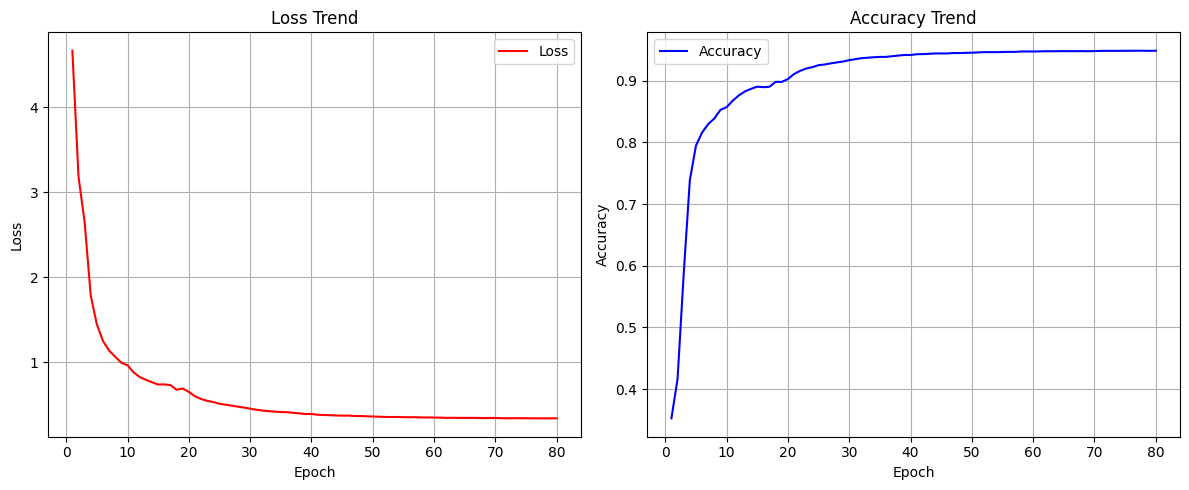

In [ ]:
# خلية 15: رسم النتائج
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS+1), loss_history, 'r-', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title('Loss Trend')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS+1), accuracy_history, 'b-', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Accuracy Trend')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
@torch.no_grad()
def visualize_predictions(loader, device, limit=100):
    model.eval()
    count = 0
    for batch in loader:
        imgs = batch['input1'].to(device)
        labels = batch['label1'].to(device)
        preds = model(imgs)
        preds_mask = torch.argmax(preds, dim=1).cpu()

        batch_size = imgs.size(0)
        for i in range(batch_size):
            if count >= limit:
                return
            img = imgs[i].cpu().permute(1, 2, 0).numpy()
            label = labels[i].squeeze(0).cpu().numpy()
            pred_mask = preds_mask[i].numpy()

            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(img)
            axs[0].set_title("Input Image")
            axs[1].imshow(label)
            axs[1].set_title("Ground Truth")
            axs[2].imshow(pred_mask)
            axs[2].set_title("Predicted Mask")
            for ax in axs:
                ax.axis("off")
            plt.show()

            count += 1


Output hidden; open in https://colab.research.google.com to view.